# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.
also want to make this dynamic if in case some one want to use GPU

In [97]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
# if below solution do not work try this 
# # For new versions of TorchVision
# wget -O MNIST.tar.gz https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/MNIST.new.tar.gz
#tar -zxvf MNIST.tar.gz
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### Step1:- Load and visualize the data

In [99]:
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
num_workers =0
#transforming image to tensor vector and sacling the image
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)


In [100]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

/Users/omtripa/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


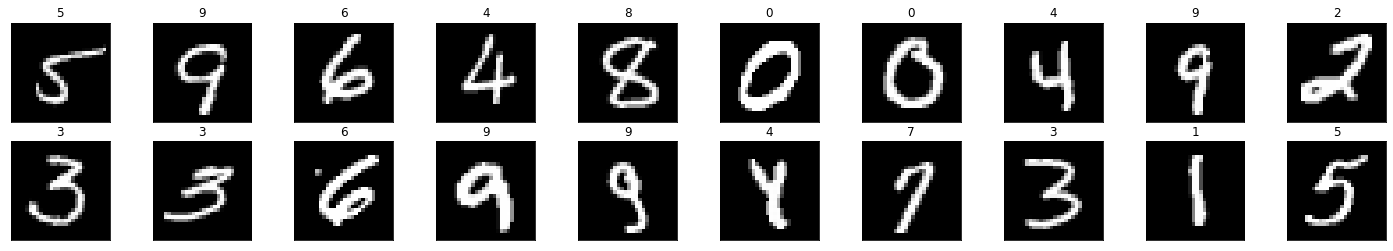

In [101]:
# visualize the data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Step2 :- Define a neural network

In [102]:
#28 * 28 is the size of input image vector
class NuralNetwork(nn.Module):
    def __init__(self):
        super(NuralNetwork, self).__init__()
        #input layer
        self.fc1 = nn.Linear(28*28, 512)
        #hidden layer 1
        self.fc2 = nn.Linear(512, 512)
        #hidden layer 2
        self.fc3 = nn.Linear(512, 10)
        #drop out layer which prevent overfitting of model
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = NuralNetwork()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
print(model)    

NuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Step3:- Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [116]:
valid_loss_min = np.inf
epochs = 30
for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    for images, targets in train_loader:
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()
        model.train()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
     
    model.eval()
    for images, targets in valid_loader:
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        valid_loss += loss.item() * images.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
        
        

Epoch: 1 	Training Loss: 0.040447 	Validation Loss: 0.014611
Validation loss decreased (inf --> 0.014611).  Saving model ...
Epoch: 2 	Training Loss: 0.038042 	Validation Loss: 0.014336
Validation loss decreased (0.014611 --> 0.014336).  Saving model ...
Epoch: 3 	Training Loss: 0.036571 	Validation Loss: 0.013853
Validation loss decreased (0.014336 --> 0.013853).  Saving model ...
Epoch: 4 	Training Loss: 0.035352 	Validation Loss: 0.013931
Epoch: 5 	Training Loss: 0.032554 	Validation Loss: 0.013402
Validation loss decreased (0.013853 --> 0.013402).  Saving model ...
Epoch: 6 	Training Loss: 0.030798 	Validation Loss: 0.013331
Validation loss decreased (0.013402 --> 0.013331).  Saving model ...
Epoch: 7 	Training Loss: 0.029706 	Validation Loss: 0.013005
Validation loss decreased (0.013331 --> 0.013005).  Saving model ...
Epoch: 8 	Training Loss: 0.027708 	Validation Loss: 0.013152
Epoch: 9 	Training Loss: 0.026193 	Validation Loss: 0.012899
Validation loss decreased (0.013005 --> 0.

In [105]:
# load the model with lowest validation model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Step 4:- Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [110]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
    if train_on_gpu:
            data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, prediction = torch.max(output, 1)
    correct_tensor = prediction.eq(target.data.view_as(prediction))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))
    

Test Loss: 0.070096

Test Accuracy of     0: 100% (56/56)
Test Accuracy of     1: 98% (67/68)
Test Accuracy of     2: 94% (48/51)
Test Accuracy of     3: 97% (34/35)
Test Accuracy of     4: 100% (43/43)
Test Accuracy of     5: 100% (39/39)
Test Accuracy of     6: 96% (49/51)
Test Accuracy of     7: 91% (45/49)
Test Accuracy of     8: 94% (54/57)
Test Accuracy of     9: 98% (50/51)


/Users/omtripa/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


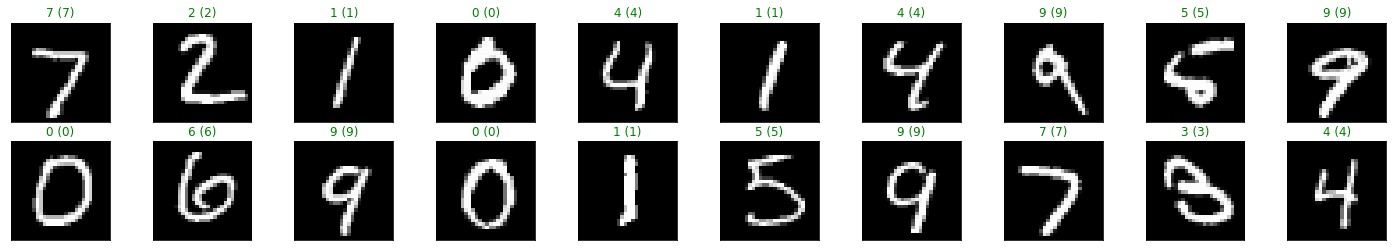

In [115]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))